In [1]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
tf.__version__

'2.4.1'

In [3]:
!pip install simpleitk

In [4]:
path = "/content/drive/MyDrive/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/"

In [5]:
files = glob(path+"**/*flair.nii.gz")

len(files)

259

# Convert to Array

In [6]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


## Visualize Flair Image

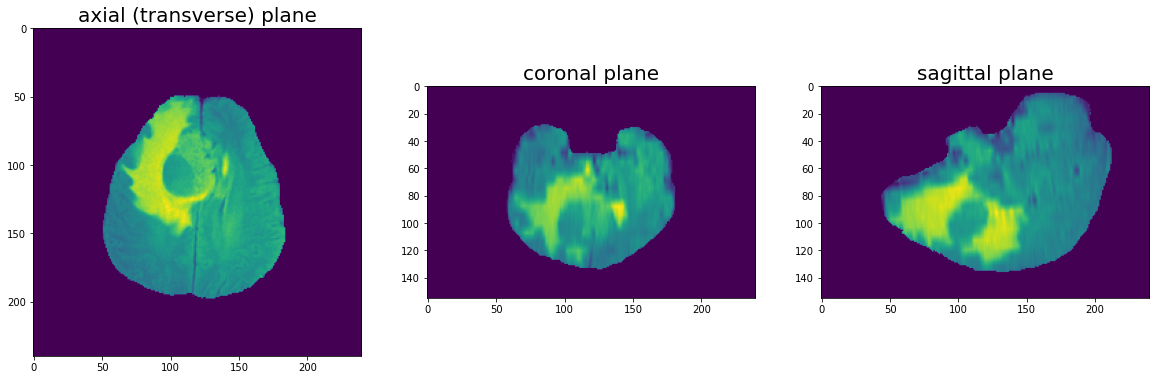

In [7]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[100,:,:])
plt.title("axial (transverse) plane", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,100,:])
plt.title("coronal plane", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,100])
plt.title("sagittal plane", fontsize=20);

## Visualize Segmented Image

In [8]:
files[1]

'/content/drive/MyDrive/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TMC_11964_1/BraTS19_TMC_11964_1_flair.nii.gz'

In [9]:
seg_img = io.imread('/content/drive/MyDrive/BraTS/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1/BraTS19_2013_11_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


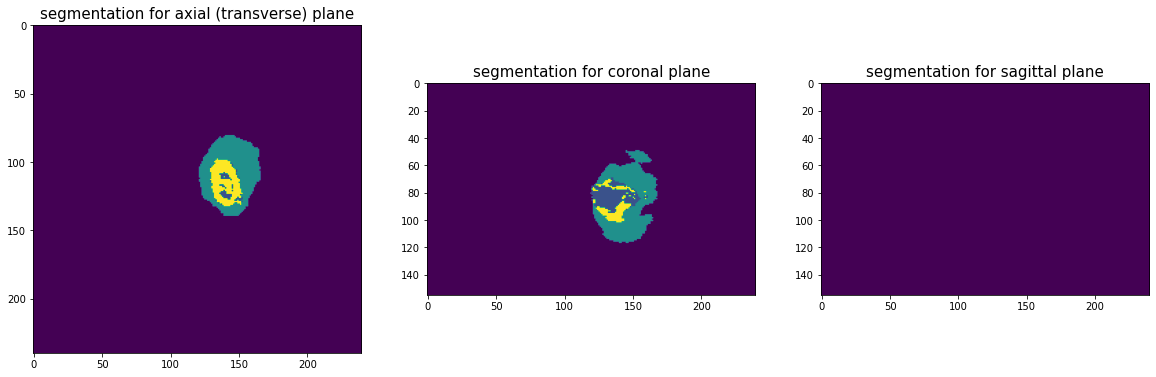

In [10]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("segmentation for coronal plane", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("segmentation for sagittal plane", fontsize=15);

# Convert to Array 

In [11]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 90):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

### np.expand_dims()

In [12]:
first_img.shape

(155, 240, 240)

In [13]:
exp = first_img[60,:,:]

exp.shape

(240, 240)

In [14]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 240, 240)

# Applying the Function

In [15]:
train = to_array(path=path, end="**/*flair.nii.gz")

In [16]:
train.shape

(7770, 1, 128, 128)

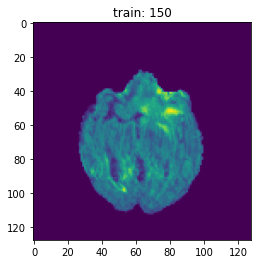

In [17]:
plt.imshow(train[150].reshape(128,128))
plt.title("train: 150");

In [55]:
t1ce = to_array(path=path, end='**/*t1ce.nii.gz')

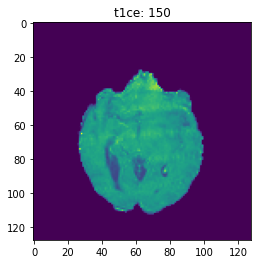

In [56]:
plt.imshow(t1ce[150].reshape(128,128))
plt.title("t1ce: 150");

# Segmented Images

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [18]:
seg_img.shape

(155, 240, 240)

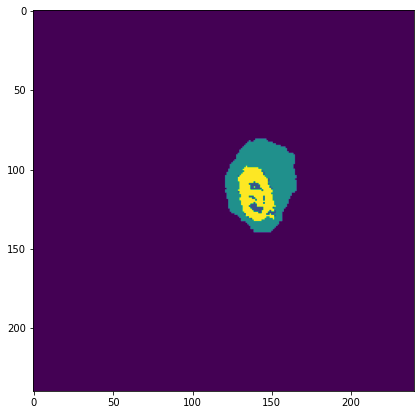

In [19]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[100,:,:]);

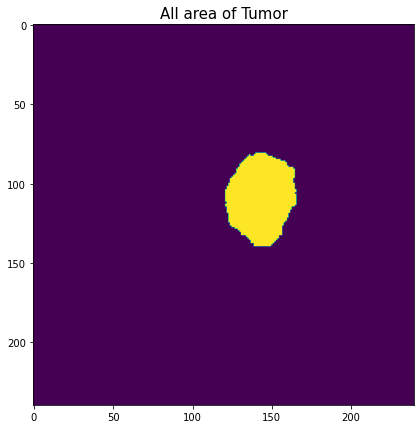

In [20]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[100,:,:])
plt.title("All area of Tumor", fontsize=15);

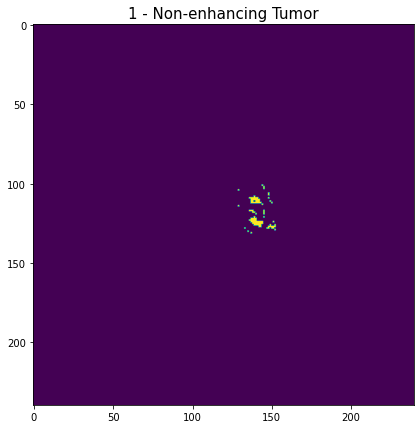

In [21]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[100,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

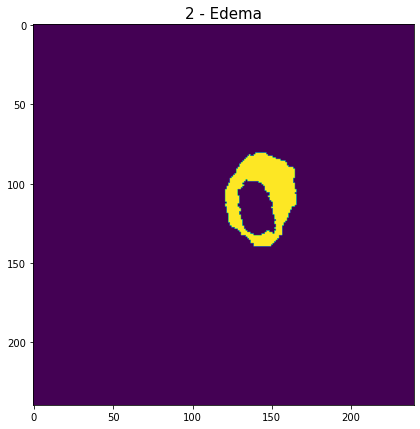

In [22]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[100,:,:])
plt.title("2 - Edema", fontsize=15);

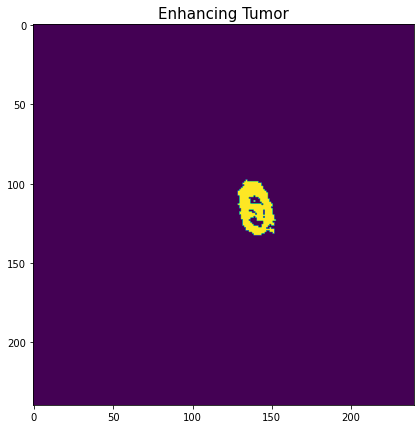

In [23]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[100,:,:])
plt.title("Enhancing Tumor", fontsize=15);

# To Array for Segmented Images

In [24]:
def seg_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(60, 90):
            img_s = img[slice,:,:]
            
            # resize
            img_s = cv2.resize(img_s, (128,128))
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [25]:
seg_all_tumor = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

seg_non_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=2)

seg_out_edema = seg_to_array(path=path, end="**/*seg.nii.gz", label=3) 

seg_enhancing = seg_to_array(path=path, end="**/*seg.nii.gz", label=4) 

seg_original = seg_to_array(path=path, end="**/*seg.nii.gz", label=0)

In [26]:
seg_all_tumor.shape

(7770, 1, 128, 128)

In [27]:
seg_non_enhancing.shape

(7770, 1, 128, 128)

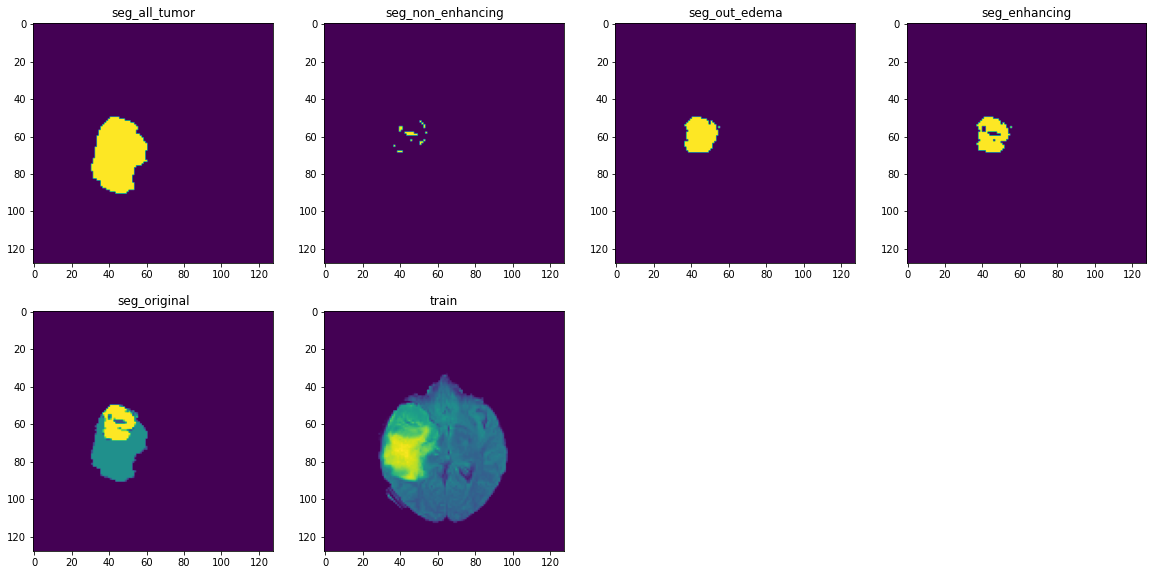

In [28]:
plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(seg_all_tumor[280].reshape(128,128))
plt.title("seg_all_tumor")

plt.subplot(3,4,2)
plt.imshow(seg_non_enhancing[280].reshape(128,128))
plt.title("seg_non_enhancing")

plt.subplot(3,4,3)
plt.imshow(seg_out_edema[280].reshape(128,128))
plt.title("seg_out_edema")

plt.subplot(3,4,4)
plt.imshow(seg_enhancing[280].reshape(128,128))
plt.title("seg_enhancing")

plt.subplot(3,4,5)
plt.imshow(seg_original[280].reshape(128,128))
plt.title("seg_original")

plt.subplot(3,4,6)
plt.imshow(train[280].reshape(128,128))
plt.title("train");

# U-NET MODEL

In [29]:
flair = to_array(path=path, end="**/*flair.nii.gz")
t2 = to_array(path=path, end="**/*t2.nii.gz")
seg = seg_to_array(path=path, end="**/*seg.nii.gz", label=1)

In [30]:
flair.shape, t2.shape, seg.shape

((7770, 1, 128, 128), (7770, 1, 128, 128), (7770, 1, 128, 128))

## Concatenate

In [31]:
X_train = np.concatenate((flair, t2), axis=1)

In [32]:
X_train.shape

(7770, 2, 128, 128)

In [33]:
X_train.dtype

dtype('float32')

# U-NET MODEL

In [34]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')


def unet():
    
    inputs = Input((2, 128 , 128))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2))(batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [35]:
model = unet()

In [36]:
model.fit(X_train, seg, validation_split=0.25, batch_size=16, epochs=30, shuffle=True)

Epoch 1/30
365/365 [==============================] - 190s 483ms/step - loss: 0.7726 - dice_coef: 0.2274 - val_loss: 0.8085 - val_dice_coef: 0.1906
Epoch 2/30
365/365 [==============================] - 171s 468ms/step - loss: 0.4723 - dice_coef: 0.5277 - val_loss: 0.3000 - val_dice_coef: 0.6967
Epoch 3/30
365/365 [==============================] - 170s 467ms/step - loss: 0.2769 - dice_coef: 0.7231 - val_loss: 0.2015 - val_dice_coef: 0.7948
Epoch 4/30
365/365 [==============================] - 170s 466ms/step - loss: 0.1894 - dice_coef: 0.8106 - val_loss: 0.2203 - val_dice_coef: 0.7761
Epoch 5/30
365/365 [==============================] - 170s 466ms/step - loss: 0.1368 - dice_coef: 0.8632 - val_loss: 0.2815 - val_dice_coef: 0.7151
Epoch 6/30
365/365 [==============================] - 171s 468ms/step - loss: 0.1068 - dice_coef: 0.8932 - val_loss: 0.2000 - val_dice_coef: 0.7963
Epoch 7/30
365/365 [==============================] - 170s 467ms/step - loss: 0.0930 - dice_coef: 0.9070 - val_l

In [37]:
model.save_weights("/content/drive/MyDrive/BraTS/model.h5")

# PREDICTION

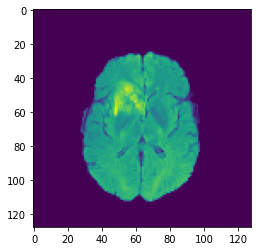

In [38]:
plt.imshow(X_train[1997][0]);

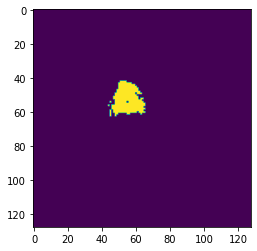

In [39]:
plt.imshow(seg[1997][0]);

In [40]:
expand_img = np.expand_dims(X_train[1997], axis=0)

pred = model.predict(expand_img)

## Visualize Prediction

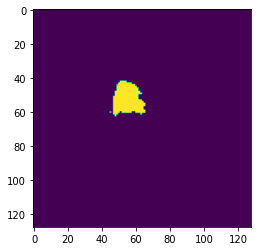

In [41]:
plt.imshow(pred[0][0]);

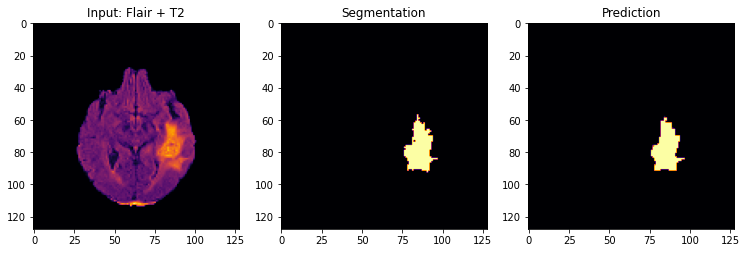

In [42]:
x = 1234

sample = np.expand_dims(X_train[x], axis=0)
pred = model.predict(sample)


fig = plt.figure(figsize=(17, 15))

plt.subplot(1,4,1)
plt.title("Input: Flair + T2")
plt.imshow(X_train[x][0], cmap="inferno")

plt.subplot(1,4,2)
plt.title("Segmentation")
plt.imshow(seg[x][0], cmap="inferno")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred[0][0], cmap="inferno");

# Cropping Images

 * First Step: 
  * Get coordinates of Tumor Center
 * Step Two:
  * Threshold
 * Step Three
  * Get coordinates that are equals 1

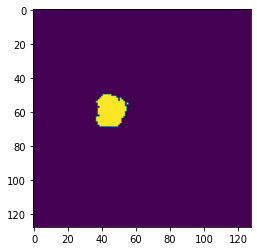

In [43]:
tmp = seg_out_edema[280,0,:,:]

tmp.shape

plt.imshow(tmp);

In [44]:
# threshold
tmp[tmp > 0.2] = 1
tmp[tmp != 1] = 0

In [45]:
index_xy = np.where(tmp==1)

In [46]:
index_xy[0]

array([50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56,
       56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65,
       65, 65, 65, 65, 65

In [52]:
index_xy[1]

array([37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50,
       50, 50, 50, 50, 50

In [53]:
center_y = (max(index_xy[0]) + min(index_xy[0])) / 2

center_y

59.0

In [54]:
center_x = (max(index_xy[1]) + min(index_xy[1])) / 2

center_x

46.0

In [57]:
img_x = np.zeros((64,64), np.float32)

img_x.shape

(64, 64)

In [59]:
x = t1ce[280,0,:,:]
x.shape

(128, 128)

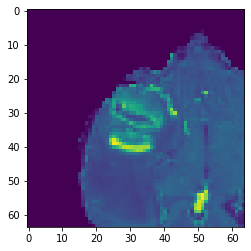

In [60]:
img_x[:,:] = x[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [61]:
seg_ = seg_out_edema[280,0,:,:]

seg_.shape

(128, 128)

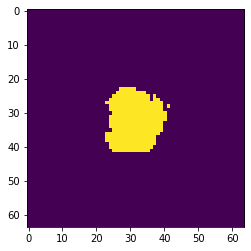

In [62]:
img_x[:,:] = seg_[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]


plt.imshow(img_x);

In [67]:
def crop_tumor(mr, seg):

  mr = mr[0]
  list_ = []

  # thresholding
  tmp = seg[0,:,:]
  tmp[tmp > 0.2] = 1
  tmp[tmp != 1] = 0
  index_xy = np.where(tmp==1)

  # some images contain no tumor !
  if index_xy[0] != []:

    center_x = (max(index_xy[1]) + min(index_xy[1])) / 2
    center_y = (max(index_xy[0]) + min(index_xy[0])) / 2

    img_x = np.zeros((64,64), np.float32)
    img_x[:,:] = mr[int(center_y - 64/2): int(center_y + 64/2), int(center_x - 64/2): int(center_x + 64/2)]
    list_.append(img_x)
  
  return np.array(list_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


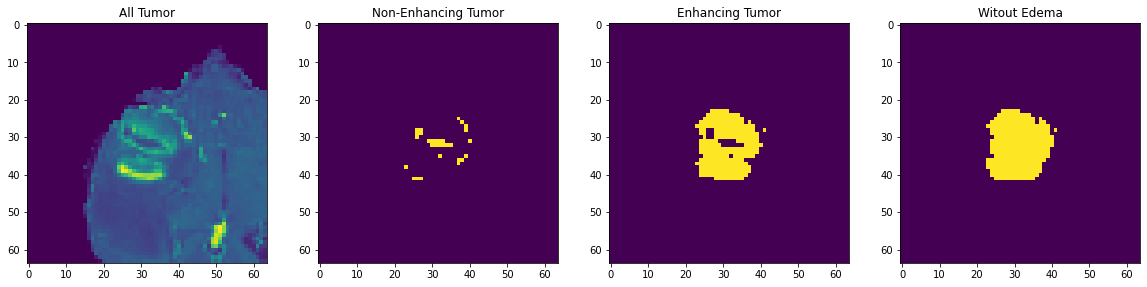

In [73]:
img_280 = crop_tumor(mr=t1ce[280], seg=seg_out_edema[280])
non_280 = crop_tumor(mr=seg_non_enhancing[280], seg=seg_out_edema[280])
enhancing_280 = crop_tumor(mr=seg_enhancing[280], seg=seg_out_edema[280])
without_edema_280 = crop_tumor(mr=seg_out_edema[280], seg=seg_out_edema[280])


plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(img_280[0])
plt.title("All Tumor")

plt.subplot(3,4,2)
plt.imshow(non_280[0])
plt.title("Non-Enhancing Tumor")

plt.subplot(3,4,3)
plt.imshow(enhancing_280[0])
plt.title("Enhancing Tumor")

plt.subplot(3,4,4)
plt.imshow(without_edema_280[0])
plt.title("Witout Edema");